In [3]:
DATAPATH=''
try:
    # On Google Drive, set path to my drive / data directory.
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
except:
    # On home computer, set path to local data directory.
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"

ZIP_FILE='BuildingData.zip'
ZIP_PATH = DATAPATH+ZIP_FILE
ELEC_FILE='electricity.csv'
MODEL_FILE='Model'  # will be used later to save models

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
from os import listdir
import csv
from zipfile import ZipFile
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot

from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
#from statsmodels.tsa.arima.model import ARIMA
#from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse
from math import sqrt

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)

In [5]:
def read_zip_to_panda(zip_filename,csv_filename):
    zip_handle = ZipFile(zip_filename)
    csv_handle = zip_handle.open(csv_filename)
    panda = pd.read_csv(csv_handle)
    return panda
def fix_date_type(panda):
    # Convert the given timestamp column to the pandas datetime data type.
    panda['timestamp'] = pd.to_datetime(panda['timestamp'], infer_datetime_format = True)
    indexed = panda.set_index(['timestamp'])
    return indexed

In [6]:
elec_df = read_zip_to_panda(ZIP_PATH,ELEC_FILE)
elec_df = fix_date_type(elec_df)
elec_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2016-01-01 00:00:00 to 2017-12-31 23:00:00
Columns: 1578 entries, Panther_parking_Lorriane to Mouse_science_Micheal
dtypes: float64(1578)
memory usage: 211.3 MB


In [7]:
elec_df = elec_df['Eagle_assembly_Portia'] #['1-1-2016':'12-31-2016']
building = elec_df
building = building.replace( 0,  4)
elec_df.describe()

count    17544.000000
mean       129.481377
std         55.910261
min          0.000000
25%         85.700000
50%        113.868550
75%        163.129375
max        354.718700
Name: Eagle_assembly_Portia, dtype: float64

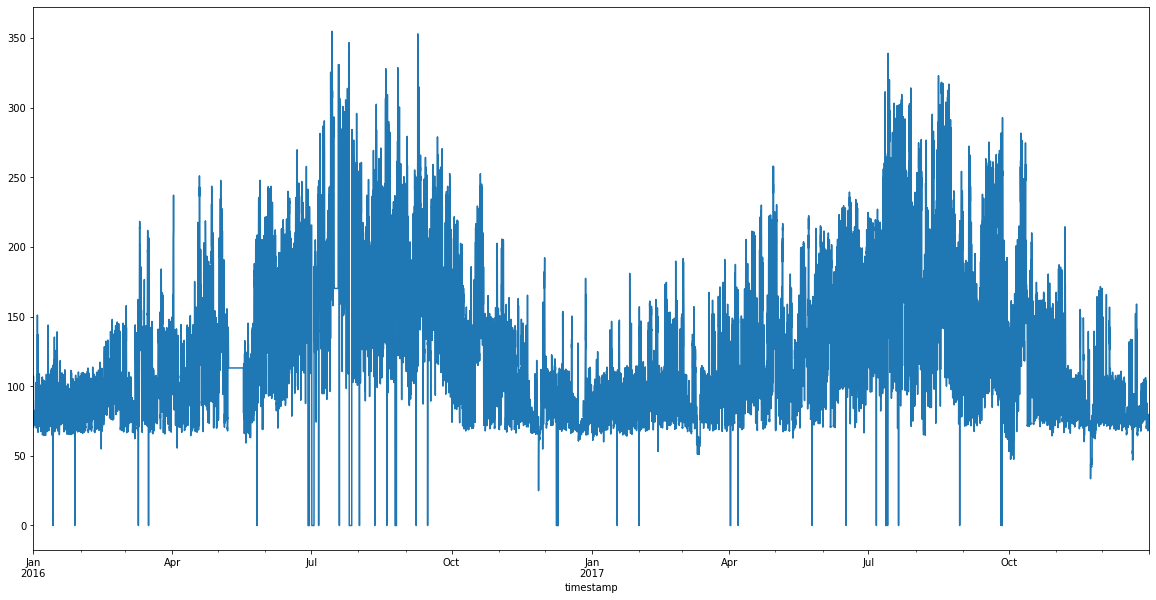

In [8]:
elec_df.plot(figsize=(20,10))

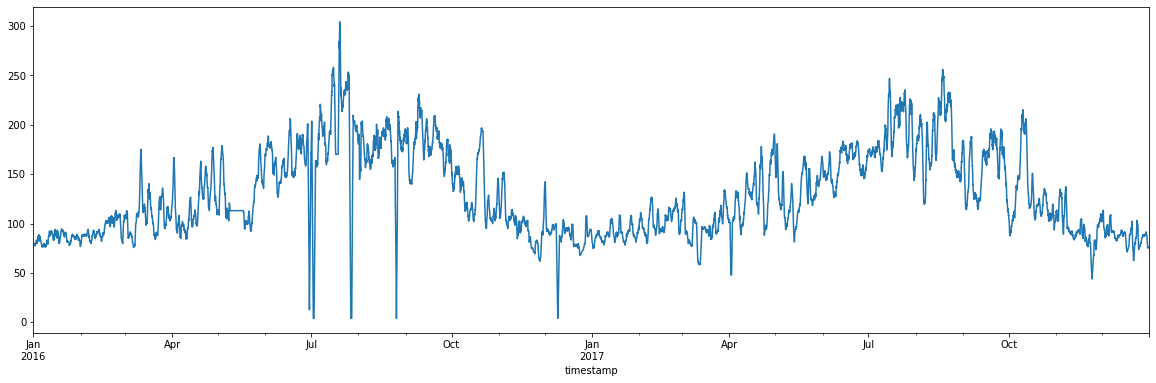

In [9]:
smooth=building.rolling(window=24).mean()
smooth.plot(figsize=(20,6))
plt.show()


## Stationarity Check

In [10]:
#Checking the Stationarity: series that has a constant mean

#Perform Building Dickey-Fuller test:
print ('Results of Dickey-Fuller Test: \n the test statistic is less than critical value, reject the null hypothesis')
dftest = adfuller(building, autolag = 'AIC') #AIC gives the information about time series 

dfoutput= pd.Series (dftest[0:4], index= ['Test Statistic','p-value: \n p-value is smaller than 0.05','#lags used', 'Number of Observations Used'])
for key, value in dftest [4].items ():
    dfoutput ['Critical Value (%s)' %key] = value

print (dfoutput)

Results of Dickey-Fuller Test: 
 the test statistic is less than critical value, reject the null hypothesis
Test Statistic                             -6.632415e+00
p-value: \n p-value is smaller than 0.05    5.671271e-09
#lags used                                  4.400000e+01
Number of Observations Used                 1.749900e+04
Critical Value (1%)                        -3.430724e+00
Critical Value (5%)                        -2.861705e+00
Critical Value (10%)                       -2.566858e+00
dtype: float64


Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

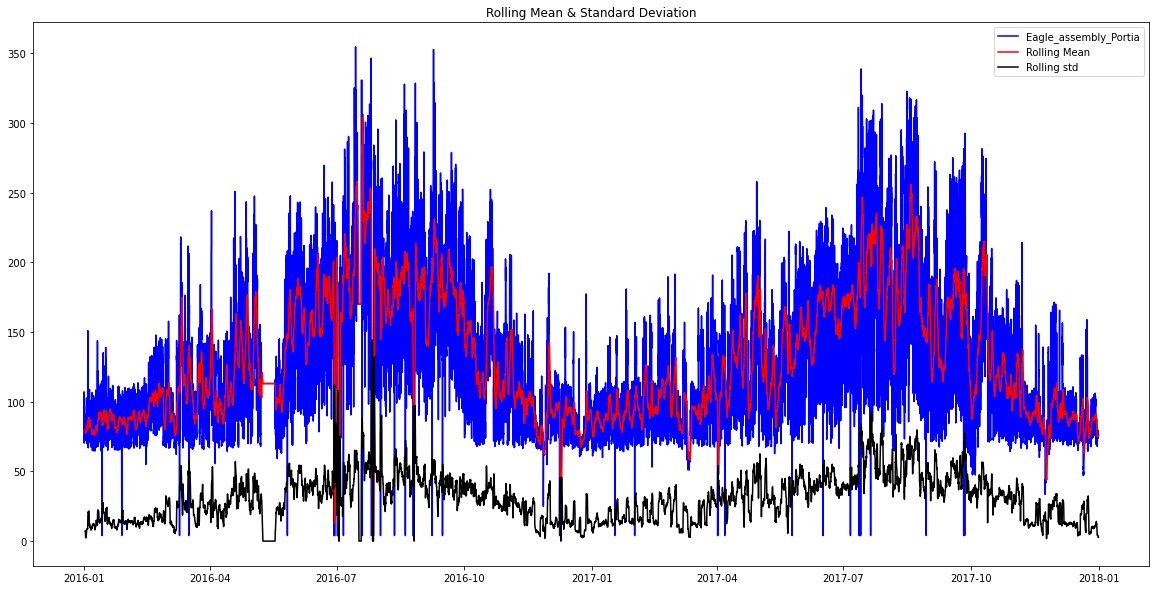

In [11]:

#Determine the rolling statistic
rolmean = building.rolling(window = 24).mean()
rolstd = building.rolling(window = 24).std()

#Checking the Stationarity
#Plot rolling statistics
plt.figure(figsize=(20,10))
orig = plt.plot (building, color = 'blue',label = 'Eagle_assembly_Portia')
mean = plt.plot (rolmean, color = 'red',label = 'Rolling Mean')
std = plt.plot (rolstd, color = 'black',label = 'Rolling std')
plt.legend (loc ='best')
plt.title ('Rolling Mean & Standard Deviation')
#plt.show (block = False)


In [12]:
#Log transformation
building = building.replace( 0,  4)
building_logscale = np.log(building)


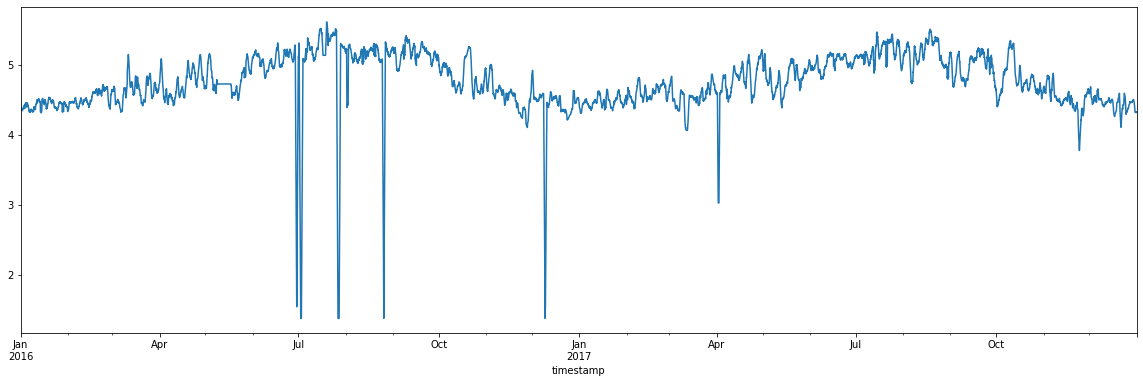

In [13]:
moving_avg =building_logscale.rolling(window = 24).mean()
moving_avg.plot(figsize=(20,6))

In [14]:
#Automatic Time Series Decomposition

decomposition = seasonal_decompose (building.values,period = 30, model = 'additive') 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize = (20,10))
fig = plt.figure(1)


plt.subplot (411)
plt.plot (building, label = 'Building Electricity')
plt.legend(loc ='best')

plt.subplot (412)
plt.plot (trend,label = 'Cyclical')
plt.legend(loc ='best')

plt.subplot (413)
plt.plot (seasonal, label = 'Seasonality')
plt.legend(loc ='best')

plt.subplot (414)
plt.plot (residual, label = 'Residual')
plt.legend(loc ='best')

plt.tight_layout()

print('The result:')
#print(decomposition.observed)
#print(decomposition.trend)
#print(decomposition.seasonal)
#print(decomposition.resid)


TypeError: ignored

## Determine the order of AR, I and MA component 
Using AFC autocorreclation plot and PACF partial autocorrelatioin plot

In [ ]:
fig = plt.figure(figsize = (20,6))
building_acf = fig.add_subplot(211)
acf_plot = sm.graphics.tsa.plot_acf (building.dropna(),lags = 40, ax = building_acf )
building_pacf = fig.add_subplot(212)
pacf_plot = sm.graphics.tsa.plot_pacf (building.dropna(),lags = 40, ax = building_pacf )

Using auto_arima function

In [ ]:

#pdq_order = auto_arima(building, trace = True)
#pdq_order.summary()

## ARIMA


AR = p = period for autoregressive model (regression the past lag value, PACF method),
<br>
Integrated = d = order of autoregression (differenced value from present and previous to eliminate the effects of seasonality; removing the trend and seasonality to make it stationary)
<br>
MA = q = periods in moving average (present value is not only depended on the past value but the error lag value as well, use the ACF method)

In [ ]:
#Build ARIMA model

model = ARIMA(building, order = (3,1,5)) #number of order generates from the auto_arima 
results_ARIMA = model.fit()


In [ ]:
pd.DataFrame (building)

In [ ]:
pred = results_ARIMA.predict(start = len (building), end = len(building)+24*7, typ = 'levels'). rename ('ARIMA predictions')
pd.DataFrame(pred)


In [ ]:
pred.plot(figsize = (20,6), legend = True)

In [ ]:
building.plot(figsize = (20,6), label = 'Train',legend = True)

pred.plot(figsize = (20,6), legend = True)


## Residuals

In [ ]:
# line plot of residuals
residuals = pd.DataFrame(results_ARIMA.resid)
residuals.plot(figsize = (15,6))
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [ ]:
print (residuals)
#results = residuals.to_csv('residuals_result.csv')

## evaluate forecasts


In [ ]:
#rmse = sqrt(mean_squared_error(building, pred))
#print('Test RMSE: %.3f' % rmse)

In [ ]:
#test.mean(),np.sqrt(test.var())

In [ ]:
plt.figure(figsize = (15,6))
plt.plot (building)
plt.plot(results_ARIMA.fittedvalues, color = 'red')

In [ ]:
print (results_ARIMA.summary())